## 1. Import libraries and sample dataset

- Episode starts with taxi at a random square and passenger at random location, and ends with the passenger being dropped off at a specified destination.
- 4 destinations: R(ed), G(reen), Y(ellow), and B(lue)

There are `500` discrete states as `25` (taxi positions) × `5` (possible passenger locations) × `4` (destination).

| Location index | Description |
| -- | --- |
| `0` | R(ed) |
| `1` | G(reen) |
| `2` | Y(ellow) |
| `3` | B(lue) |
| `4` | In taxi |

There are `6` discrete deterministic actions:

| Action index | Description |
| -- | -- |
| `0` | move south |
| `1` | move north |
| `2` | move east |
| `3` | move west |
| `4` | pickup passenger |
| `5` | drop off passenger |

The reward functions acts like this:

| Reward value | Description |
| -- | -- |
| `-1` | Per step reward |
| `+20` | Delivering passenger |
| `-10` | Executing "pickup" or "drop-off" actions illegally |

### Rendering

These are the color indications,

| Color | Description |
| -- | -- |
| Blue | Passenger |
| Magenta | Destination |
| Yellow | Empty taxi |
| Green | Full taxi |

These are the letter indications,

| Letter | Description |
| -- | -- |
| R | R(ed) destination |
| G | G(reen) destination |
| Y | Y(ellow) destination |
| B | B(lue) destination |

The block represent the taxi.

In [14]:
import gym
import numpy as np
import pandas as pd

streets = gym.make("Taxi-v3").env
streets.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## 2. Find optimized policy and state-action function from Monte Carlo

Credits: [ANKIT CHOUDHARY, 2018](https://www.analyticsvidhya.com/blog/2018/11/reinforcement-learning-introduction-monte-carlo-learning-openai-gym/)

In [15]:
import random

discount_factor = 0.95
epsilon = 0.75 # Higher epsilon to give the other actions more chance of exploration.

no_of_states = streets.observation_space.n
no_of_actions = streets.action_space.n
no_of_episodes = 25

# Generate a random policy
policy = np.ones([no_of_states, no_of_actions]) / no_of_actions
Q = np.zeros([no_of_states, no_of_actions])
R = np.zeros([no_of_states, no_of_actions])
N = np.zeros([no_of_states, no_of_actions])


def next_action(state):
    choose = [round((1 - 0.5) / (no_of_actions - 1), 2) for _ in range(no_of_actions)]
    choose[random.randint(0, no_of_actions - 1)] = 0.5
    return np.random.choice(np.arange(no_of_actions), p=choose)


def get_episode_steps():
    is_terminal_state = False
    state = streets.reset()
    steps = []

    while not is_terminal_state:
        action = next_action(state)
        next_state, reward, is_terminal_state, _ = streets.step(action)
        steps.append((state, action, reward))
        state = next_state
    
    return steps


for i in range(no_of_episodes):
    G = 0
    states, actions, rewards = zip(*get_episode_steps())

    for index, state in enumerate(states):
        action = actions[index]
        reward = rewards[index]

        R[state][action] += np.sum(rewards) * discount_factor
        N[state][action] += 1
        Q[state][action] = np.divide(R[state][action], N[state][action])
    
# Setting a stochastic policy with ε-soft.
for state in range(no_of_states):
    policy[state] = np.ones(no_of_actions) * epsilon / no_of_actions
    policy[state][np.argmax(Q[state])] = 1 - epsilon + (epsilon / no_of_actions)

print(f'Completed with {no_of_episodes} episodes')

Completed with 25 episodes


## 3. Find the amount of steps taken upon using model algorithm

Reset the environment after having pre-learnt it and find the amount of steps taken to reach goal.

Display the min, max and avg steps after it is done.

In [18]:
def episode_steps():
    current_state = streets.reset()
    reward = 0
    no_of_steps = 0

    while reward != 20:
        state, reward, _, _ = streets.step(np.random.choice(np.arange(no_of_actions), p=policy[current_state])) 
        current_state = state
        no_of_steps += 1
    
    return no_of_steps

episode_dist = np.array([episode_steps() for i in range(25)])

print(f'Min steps={np.min(episode_dist)}, Avg steps={np.round(np.average(episode_dist), 1)}, Max steps={np.max(episode_dist)}')
streets.render()

Min steps=87, Avg steps=8932.7, Max steps=63781
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


## 4. Display episode steps distribution

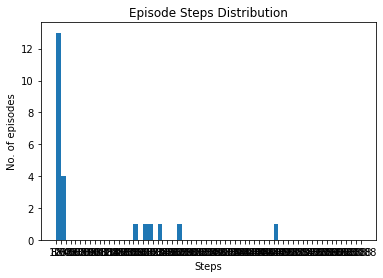

In [21]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1)
bins = [i + 1 for i in range(np.min(episode_dist), np.max(episode_dist), 1000)]

ax.hist(episode_dist, bins=bins)
ax.set_title("Episode Steps Distribution")
ax.set_xticks(bins)
ax.set_xlabel('Steps')
ax.set_ylabel('No. of episodes')
plt.show()